In [1]:
pip install imbalanced-learn


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Shape of X_train: (1253, 561)
Shape of X_test: (314, 561)
Shape of y_train: (1253,)
Shape of y_test: (314,)

Target distribution in y_train (before SMOTE):
0    1173
1      80
Name: target, dtype: int64

Target distribution in y_test:
0    290
1     24
Name: target, dtype: int64

Shape of X_train after SMOTE: (2346, 561)
Shape of y_train after SMOTE: (2346,)

Target distribution in y_train after SMOTE:
0    1173
1    1173
Name: target, dtype: int64


C:\Users\desktop1\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy on the Test Set (after SMOTE): 0.9140

Classification Report (after SMOTE):
              precision    recall  f1-score   support

           0       0.93      0.99      0.95       290
           1       0.20      0.04      0.07        24

    accuracy                           0.91       314
   macro avg       0.56      0.51      0.51       314
weighted avg       0.87      0.91      0.89       314



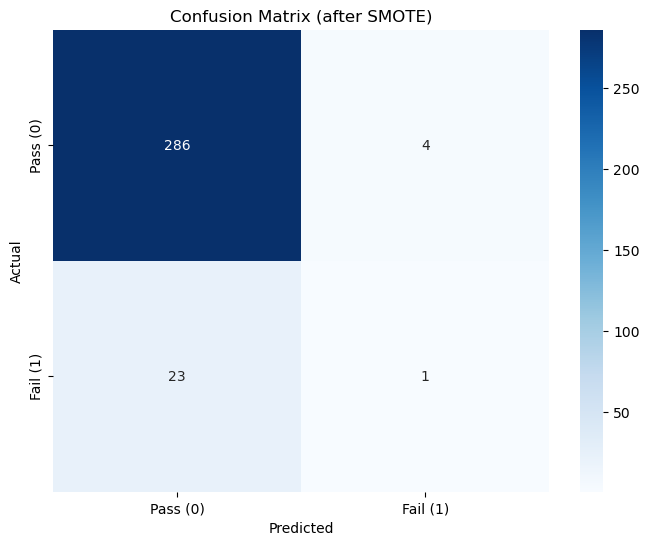

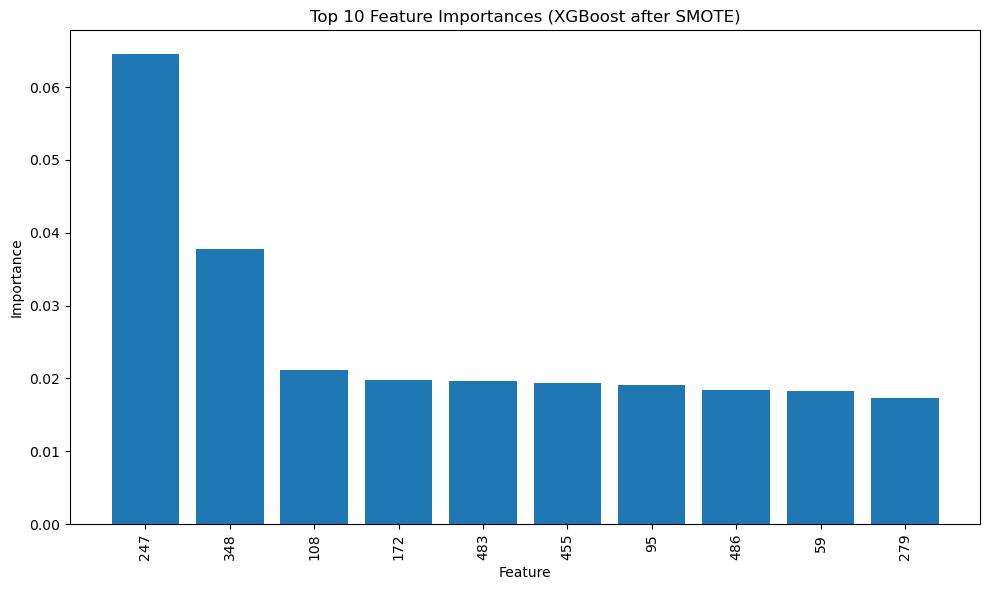

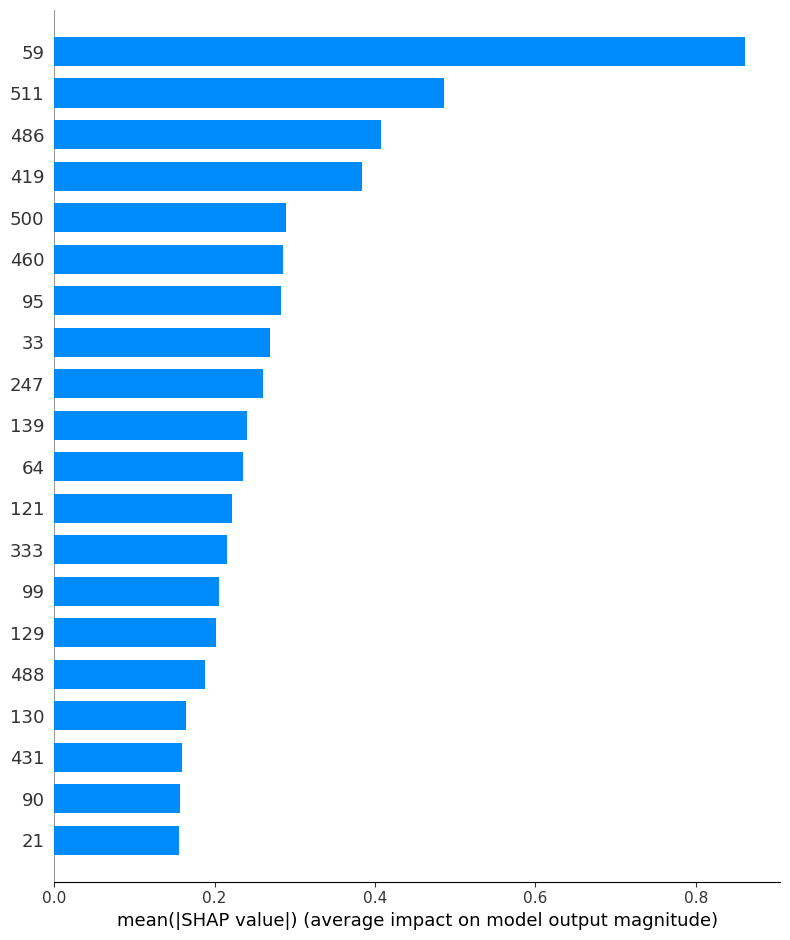

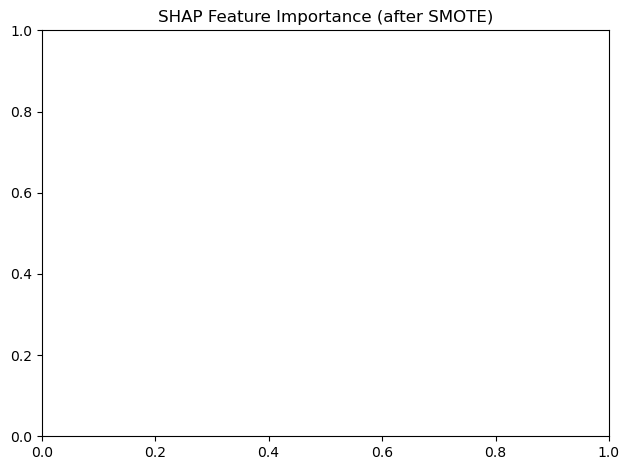

<Figure size 1000x600 with 0 Axes>

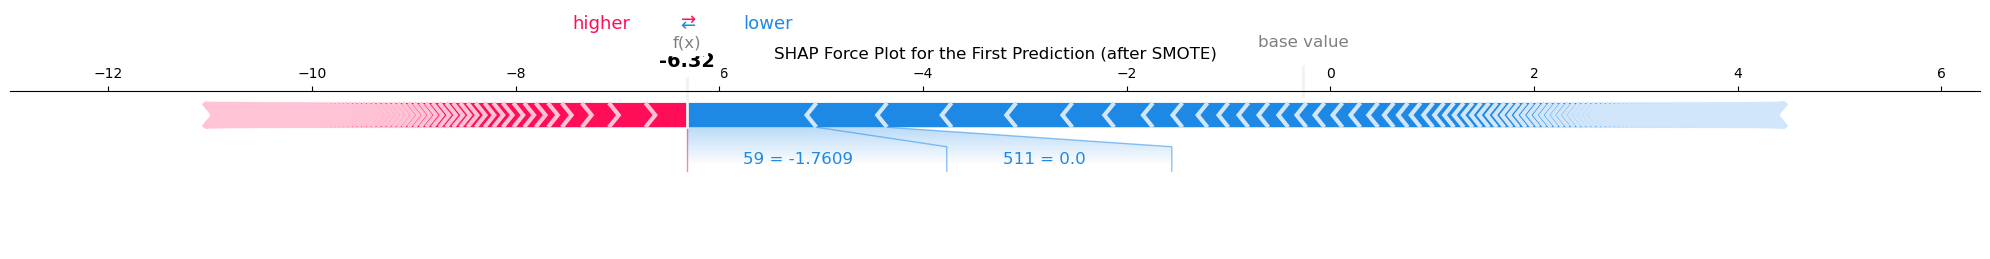


Trained XGBoost model (with SMOTE) saved to ../src/model/model_smote.pkl


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# --- Load the preprocessed data ---
preprocessed_file = '../data/processed/secom_preprocessed.csv'
df_processed = pd.read_csv(preprocessed_file)

# --- Separate features (X) and target (y) ---
X = df_processed.drop('target', axis=1)
y = df_processed['target']

# --- Split the data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("\nTarget distribution in y_train (before SMOTE):")
print(y_train.value_counts())
print("\nTarget distribution in y_test:")
print(y_test.value_counts())

# --- Apply SMOTE to the training data ---
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nShape of X_train after SMOTE:", X_train_smote.shape)
print("Shape of y_train after SMOTE:", y_train_smote.shape)
print("\nTarget distribution in y_train after SMOTE:")
print(y_train_smote.value_counts())

# --- Initialize and Train the XGBoost Model on the SMOTE data ---
model_smote = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_smote.fit(X_train_smote, y_train_smote)

# --- Make Predictions on the Test Set ---
y_pred_smote = model_smote.predict(X_test)

# --- Evaluate the Model ---
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"\nAccuracy on the Test Set (after SMOTE): {accuracy_smote:.4f}")

print("\nClassification Report (after SMOTE):")
print(classification_report(y_test, y_pred_smote))

# --- Confusion Matrix ---
cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', xticklabels=['Pass (0)', 'Fail (1)'], yticklabels=['Pass (0)', 'Fail (1)'])
plt.title('Confusion Matrix (after SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Feature Importance using XGBoost ---
feature_importance_smote = model_smote.feature_importances_
sorted_indices_smote = feature_importance_smote.argsort()[::-1]
top_n = 10

plt.figure(figsize=(10, 6))
plt.title(f'Top {top_n} Feature Importances (XGBoost after SMOTE)')
plt.bar(range(top_n), feature_importance_smote[sorted_indices_smote[:top_n]], align="center")
plt.xticks(range(top_n), X_train.columns[sorted_indices_smote[:top_n]], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

# --- SHAP Analysis (for interpretability) ---
explainer_smote = shap.TreeExplainer(model_smote)
shap_values_smote = explainer_smote.shap_values(X_test)

# Summary plot of SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_smote, X_test, plot_type="bar")
plt.title('SHAP Feature Importance (after SMOTE)')
plt.tight_layout()
plt.show()

# Individual SHAP value plot (for the first prediction)
plt.figure(figsize=(10, 6))
shap.force_plot(explainer_smote.expected_value, shap_values_smote[0,:], X_test.iloc[0,:], matplotlib=True, show=False)
plt.title('SHAP Force Plot for the First Prediction (after SMOTE)')
plt.tight_layout()
plt.show()

# --- Save the Trained XGBoost Model (SMOTE version) ---
model_filename_smote = '../src/model/model_smote.pkl'
pickle.dump(model_smote, open(model_filename_smote, 'wb'))
print(f"\nTrained XGBoost model (with SMOTE) saved to {model_filename_smote}")

In [3]:
print(X_test.head().to_json(orient='values'))

[[2929.6,2564.91,2216.4778,1242.235,0.8379,100.0,105.1111,0.1233,1.519,-0.0053,-0.0124,0.966,199.3192,0.0,7.2128,400.3552,10.6137,0.9802,188.7055,12.4618,1.4033,-5962.0,2517.75,-3781.0,4460.5,1.294,2.0393,7.257,69.0444,1.6556,0.1362,3.4756,84.7007,8.7283,49.884,63.9335,50.116,66.2469,86.6108,118.793,14.88,5.52,70.0,360.6155,9.5881,146.6436,750.0185,1.1979,136.6527,1.0,643.9118,208.2604,0.0,4.61,4.869,2855.0,0.923,0.9466,4.5698,-1.7609,361.8009,9.774,124.8827,12.8948,21.7609,31.1484,718.8701,0.9017,145.7055,1.0,632.3891,79.8047,0.0,-0.021,-0.0376,0.0294,-0.0254,-0.008,-0.1202,-0.0263,0.0178,6.4292,0.1375,2.4402,0.9683,1743.9933,0.1592,8611.06,0.0447,0.0006,-0.0021,0.0001,0.0,-0.099,0.0,0.161,0.0102,0.0001,0.0001,-0.0201,-0.0089,-0.0001,-0.0006,0.0021,0.1403,0.0851,0.4592,0.9252,0.0,712.8031,0.9919,58.0641,0.6029,0.9776,6.2913,15.92,4.92,15.96,15.96,1.399,2.471,0.7857,3.062,-0.0946,0.7436,0.9971,2.3063,1006.0844,39.14,122.0,182.5,180.0,53.3,180.863,0.2243,0.0,3.78,0.0043,0.0842,0.0385,0.